In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost

raw_target_dataset = pd.read_csv('/mnt/data/target_apartments1_wn.csv')
raw_target_dataset.drop(columns=['point'], inplace=True)
dummies = pd.get_dummies(raw_target_dataset['neighborhood'])
raw_target_dataset = pd.concat([raw_target_dataset, dummies], axis=1).drop(columns='neighborhood')

In [2]:
raw_simulated_dataset = pd.read_csv('/mnt/data/simulated_listings1_wn.csv')
raw_simulated_dataset[['latitude', 'longitude']] = raw_simulated_dataset[['latitude', 'longitude']].astype(float)
raw_simulated_dataset.drop(columns=['point','time_on_market', 'sold'], inplace=True)
dummies = pd.get_dummies(raw_simulated_dataset['neighborhood'])
raw_simulated_dataset = pd.concat([raw_simulated_dataset, dummies], axis=1).drop(columns='neighborhood')

Adicionar neighboorhoods faltantes

In [3]:
def create_missing_columns(raw_simulated_dataset, raw_target_dataset):
    adresses_to_add_columns = list(set(raw_simulated_dataset) - set(raw_target_dataset))
    adresses_to_add_columns

    for item in adresses_to_add_columns:
        raw_target_dataset[item]=0
    raw_target_dataset.columns = raw_simulated_dataset.columns 
    return raw_simulated_dataset

In [4]:
raw_simulated_dataset = create_missing_columns(raw_simulated_dataset, raw_target_dataset)

In [5]:
# load
file_name = "/mnt/data/xgb_price_regressor.pkl"
price_model = pickle.load(open(file_name, "rb"))

In [6]:
# load
file_name = "/mnt/data/xgb_liquidity_survival_cox.pkl"
liquidity_model = pickle.load(open(file_name, "rb"))

# Prever preço de venda para targets apartaments

Diretrizes:
- Pagamos exatamente o valor pedido pelo proprietário (coluna value na base
target_apartments.csv ).
- A reforma traz o apartamento para o melhor estado de conservação possível
( interior_quality=3 ).
- O capital disponível para compra dos apartamentos é de R$ 150 milhões.

Passando todos os 'interior_quality' para 3 antes de prever o preço de venda

In [7]:
raw_target_dataset['interior_quality']=3

In [8]:
X= raw_target_dataset.drop(['value'], axis=1)
sell_value_preds = price_model.predict(X)

In [9]:
raw_target_dataset = raw_target_dataset.rename(columns={'value': 'buy_value'})
raw_target_dataset['value']=sell_value_preds

# Prever Liquidity (time_on_market) com o sell_value

In [11]:
X= raw_target_dataset.drop(['buy_value'], axis=1)
X.columns = raw_simulated_dataset.columns 
X_dmatrix = xgboost.DMatrix(X)
time_on_market_pred = liquidity_model.predict(X_dmatrix)
raw_target_dataset['time_on_market'] = time_on_market_pred

In [15]:
rank_df = raw_target_dataset[['buy_value', 'value', 'time_on_market']]
rank_df['money_per_time'] = (rank_df['value'] - rank_df['buy_value'])/ rank_df['time_on_market']
rank_df

/tmp/ipykernel_16376/1063359401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df['money_per_time'] = (rank_df['value'] - rank_df['buy_value'])/ rank_df['time_on_market']


,buy_value,value,time_on_market,money_per_time
0,454377,5.000146e+05,4.397466,10378.165073
1,1500960,1.246756e+06,11.126555,-22846.558515
2,1045980,9.176501e+05,11.970856,-10720.192280
3,3707770,3.409410e+06,103.703835,-2877.044049
4,1007670,1.128824e+06,16.187449,7484.463965
...,...,...,...,...
8363,1276480,1.545236e+06,32.174469,8353.071034
8364,3543890,3.929622e+06,106.527092,3620.975593
8365,1088360,9.872470e+05,14.001967,-7221.342322
8366,2727660,2.010821e+06,31.254883,-22935.272364


In [24]:
rank_df_ordered = rank_df.sort_values(by=['money_per_time'], ascending=False)
rank_df_ordered

,buy_value,value,time_on_market,money_per_time
3535,160756,404048.90625,2.460307,98887.219292
8357,523050,905019.25000,3.872643,98632.710042
976,345007,481435.37500,1.545618,88267.851739
5167,240630,450533.68750,2.593192,80944.148355
8201,196030,413204.78125,2.760945,78659.573468
...,...,...,...,...
904,1080240,585539.75000,4.781138,-103469.133610
1345,964503,536429.68750,3.849054,-111215.197705
2145,733022,425408.40625,2.711598,-113443.670461
8277,964503,538736.06250,3.376651,-126091.500569


In [26]:
rank_df_ordered['cum_sum'] = rank_df_ordered['value'].cumsum()
best_apts_df = rank_df_ordered[rank_df_ordered['cum_sum']<150000000]
best_apts_df

,buy_value,value,time_on_market,money_per_time,cum_sum
3535,160756,4.040489e+05,2.460307,98887.219292,4.040489e+05
8357,523050,9.050192e+05,3.872643,98632.710042,1.309068e+06
976,345007,4.814354e+05,1.545618,88267.851739,1.790504e+06
5167,240630,4.505337e+05,2.593192,80944.148355,2.241037e+06
8201,196030,4.132048e+05,2.760945,78659.573468,2.654242e+06
...,...,...,...,...,...
4604,465277,5.936421e+05,4.194706,30601.694502,1.470020e+08
955,460339,5.953059e+05,4.435583,30428.231987,1.475973e+08
8052,314495,4.683800e+05,5.072826,30335.162840,1.480657e+08
692,538160,7.573234e+05,7.235702,30289.173926,1.488230e+08


<AxesSubplot:ylabel='Frequency'>

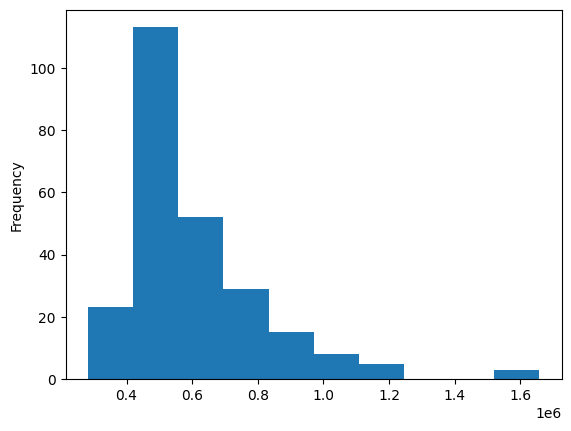

In [27]:
best_apts_df['value'].plot.hist()